In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)

2.9.1


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

### Preprocess data

what need to be predicted is NO2 level

In [4]:
df = pd.read_csv('Beijing_air_quality_Aotizhongxin.csv')
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
df.tail()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin
35063,35064,2017,2,28,23,19.0,31.0,10.0,79.0,600.0,42.0,8.6,1014.1,-15.9,0.0,NNE,1.3,Aotizhongxin


In [6]:
df.isna().sum()

No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

In [7]:
df.shape

(35064, 18)

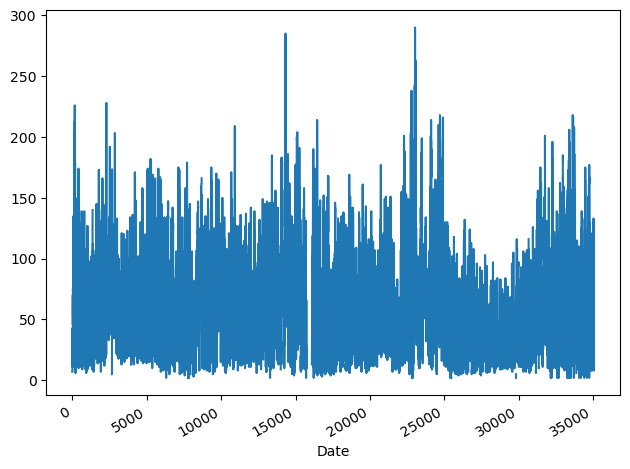

In [8]:
fig, ax = plt.subplots()
ax.plot(df['NO2'])
ax.set_xlabel('Date')


fig.autofmt_xdate()
plt.tight_layout()

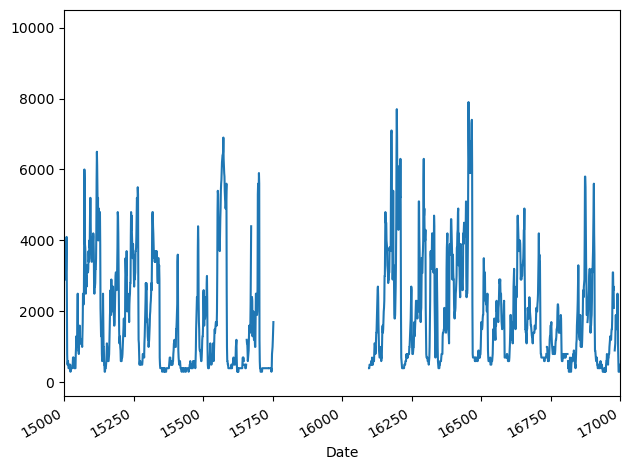

In [9]:
fig, ax = plt.subplots()
ax.plot(df['CO'])
ax.set_xlabel('Date')
ax.set_xlim(15000,17000)

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
df_new = df[16150:]
df_new.isna().sum()

No           0
year         0
month        0
day          0
hour         0
PM2.5      409
PM10       226
SO2        261
NO2        360
CO         326
O3         557
TEMP        20
PRES        20
DEWP        20
RAIN        20
wd          78
WSPM        14
station      0
dtype: int64

In [11]:
df_new['datetime'] = pd.to_datetime(df_new[['year','month','day','hour']])
df_new = df_new.drop(['year','month','day','hour'],axis = 1)
df_new.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
16150,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.0,SW,0.7,Aotizhongxin,2015-01-02 22:00:00
16151,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.0,NNW,0.7,Aotizhongxin,2015-01-02 23:00:00
16152,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.0,SSE,0.4,Aotizhongxin,2015-01-03 00:00:00
16153,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.0,ESE,0.4,Aotizhongxin,2015-01-03 01:00:00
16154,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,0.0,NE,1.1,Aotizhongxin,2015-01-03 02:00:00


In [12]:
df_new = df_new.fillna(df_new.groupby(df_new.datetime.dt.hour).transform('mean'))
df_new['wd'] = df_new['wd'].fillna(df_new['wd'].value_counts().index.tolist()[0])
df_new.isna().sum()

No          0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
station     0
datetime    0
dtype: int64

In [13]:
df_new = df_new.reset_index(drop=True)
df_new

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
0,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.0,SW,0.7,Aotizhongxin,2015-01-02 22:00:00
1,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.0,NNW,0.7,Aotizhongxin,2015-01-02 23:00:00
2,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.0,SSE,0.4,Aotizhongxin,2015-01-03 00:00:00
3,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.0,ESE,0.4,Aotizhongxin,2015-01-03 01:00:00
4,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,0.0,NE,1.1,Aotizhongxin,2015-01-03 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18909,35060,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin,2017-02-28 19:00:00
18910,35061,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin,2017-02-28 20:00:00
18911,35062,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin,2017-02-28 21:00:00
18912,35063,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin,2017-02-28 22:00:00


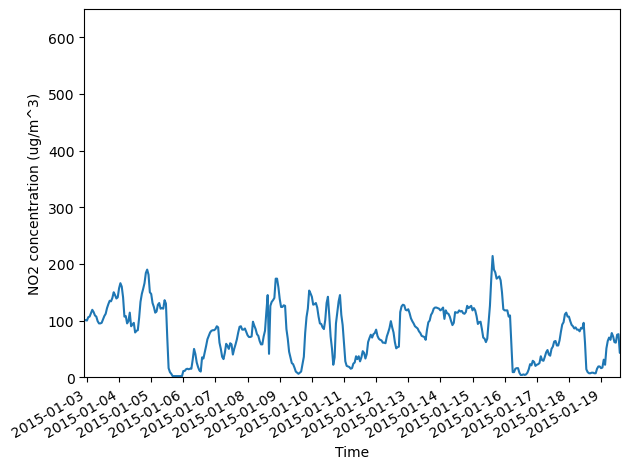

In [17]:
fig, ax = plt.subplots()

ax.plot(df_new['NO2'])
ax.set_xlabel('Time')
ax.set_ylabel('NO2 concentration (ug/m^3)')

plt.xticks(np.arange(2, 400, 24), ['2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18', '2015-01-19'])
plt.ylim(0, 650)
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
df_new.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No,18914.0,25607.500000,5460.145831,16151.0,20879.250,25607.5,30335.75,35064.0
PM2.5,18914.0,79.407220,83.816615,3.0,19.000,54.0,107.00,898.0
PM10,18914.0,103.687485,95.725767,3.0,33.225,78.0,143.00,984.0
SO2,18914.0,13.201725,17.090182,2.0,2.000,7.0,16.00,341.0
NO2,18914.0,55.560272,37.834273,2.0,26.000,47.0,77.00,290.0
CO,18914.0,1324.737573,1351.213878,100.0,500.000,900.0,1600.00,10000.0
O3,18914.0,61.602319,58.980450,2.0,13.000,49.0,87.00,423.0
TEMP,18914.0,12.741331,11.751367,-16.8,2.000,13.0,23.10,38.8
PRES,18914.0,1013.480721,10.470266,987.5,1004.900,1013.2,1022.10,1042.0
DEWP,18914.0,1.399363,13.830859,-35.3,-10.100,1.3,14.00,27.3


In [19]:
df_new = df_new.drop(['No','RAIN','wd','station'],axis = 1)
df_new.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,datetime
0,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.7,2015-01-02 22:00:00
1,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.7,2015-01-02 23:00:00
2,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4,2015-01-03 00:00:00
3,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.4,2015-01-03 01:00:00
4,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,1.1,2015-01-03 02:00:00


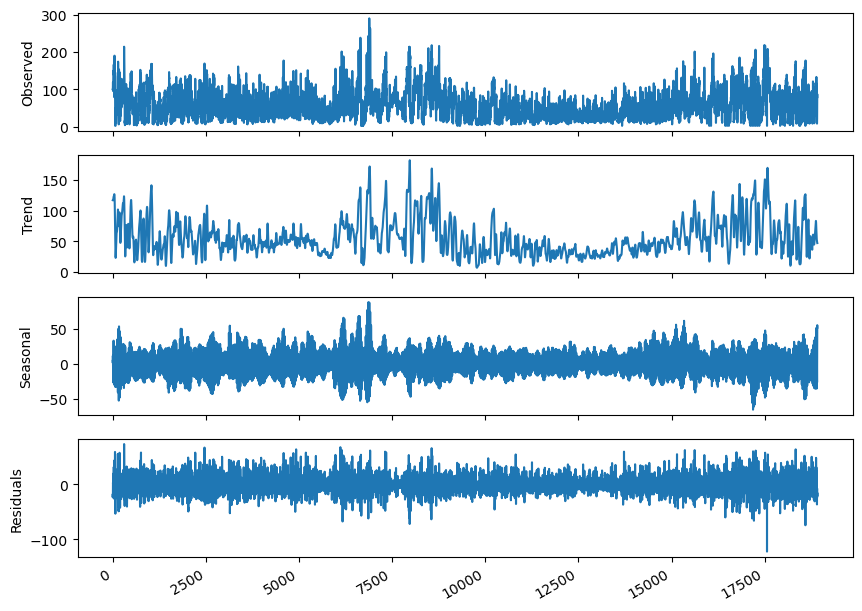

In [20]:
# Using normal decomposition to find trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose, STL
decomposition = STL(df_new['NO2'], period=24).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.show()

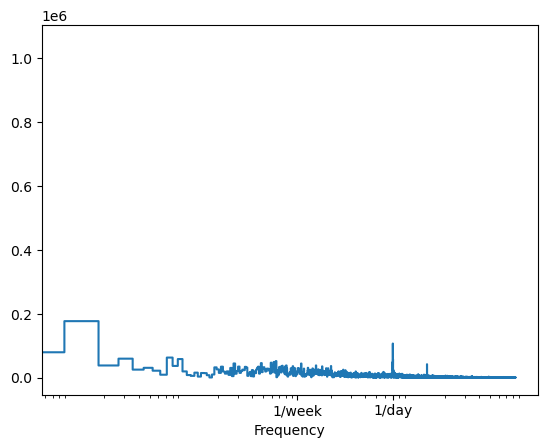

In [22]:
# Using Fourier transforms to visualize the frequency and amplitude of the data
fft = tf.signal.rfft(df_new['NO2'])
frequencies_per_dataset = np.arange(0, len(fft))
weeks_per_dataset = len(df_new)/(24*7)
frequencies_per_week = frequencies_per_dataset/weeks_per_dataset

plt.step(frequencies_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1,7],['1/week', '1/day'])
plt.xlabel('Frequency')
plt.show()

That little peak on daily frequency -> daily seasonality

In [23]:
# Encode timestamp using sine and cosine

timestamp_s = pd.to_datetime(df_new['datetime']).map(datetime.datetime.timestamp)

day = 24*60*60

df_new['day_sin'] = (np.sin(timestamp_s*(2*np.pi/day))).values
df_new['day_cos'] = (np.cos(timestamp_s*(2*np.pi/day))).values

df_new = df_new.drop(['datetime'], axis = 1)
df_new.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,day_sin,day_cos
0,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.7,-0.707107,-7.071068e-01
1,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.7,-0.866025,-5.000000e-01
2,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4,-0.965926,-2.588190e-01
3,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.4,-1.000000,-2.159137e-12
4,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,1.1,-0.965926,2.588190e-01


In [24]:
n = len(df_new)
train_df = df_new[0:int(n*0.7)]
val_df = df_new[int(n*0.7):int(n*0.9)]
test_df = df_new[int(n*0.9):]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(13239, 12)
(3783, 12)
(1892, 12)


In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [28]:
train_df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,day_sin,day_cos
0,0.128492,0.146789,0.165192,0.340278,0.191919,0.000000,0.212230,0.614679,0.296721,0.062500,0.146447,0.146447
1,0.149721,0.179409,0.179941,0.343750,0.202020,0.000000,0.194245,0.559633,0.344262,0.062500,0.066987,0.250000
2,0.154190,0.216106,0.168142,0.340278,0.222222,0.000000,0.176259,0.522936,0.318033,0.035714,0.017037,0.370590
3,0.148603,0.158002,0.185841,0.361111,0.292929,0.000000,0.176259,0.522936,0.370492,0.035714,0.000000,0.500000
4,0.144134,0.163099,0.159292,0.364583,0.292929,0.000000,0.194245,0.486239,0.301639,0.098214,0.017037,0.629410
...,...,...,...,...,...,...,...,...,...,...,...,...
13234,0.130726,0.119266,0.008850,0.135417,0.121212,0.109264,0.776978,0.383486,0.921311,0.160714,0.629410,0.982963
13235,0.124022,0.113150,0.020649,0.131944,0.121212,0.175772,0.802158,0.381651,0.921311,0.089286,0.750000,0.933013
13236,0.129609,0.118247,0.026549,0.128472,0.131313,0.239905,0.812950,0.377982,0.913115,0.142857,0.853553,0.853553
13237,0.135196,0.123344,0.032448,0.121528,0.131313,0.344418,0.843525,0.376147,0.913115,0.133929,0.933013,0.750000


### Prepare for Deep Learning Modeling

In [62]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [75]:
# Define WindowGenerator class
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
              [labels[:, :, self.column_indices[name]] for name in self.label_columns],
              axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                  label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                          edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
          # No example batch was found, so get one from the `.train` dataset
          result = next(iter(self.train))
          # And cache it for next time
          self._example = result
        return result


In [76]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [77]:
# Build a dictionary that store columns name and their index
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [78]:
multi_window = WindowGenerator(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [79]:
#Create a dict to hold model performance score
val_performance = {}
performance = {}

#### Baseline Model

In [80]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [81]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 881us/step - loss: 0.1443 - mean_absolute_error: 0.2820


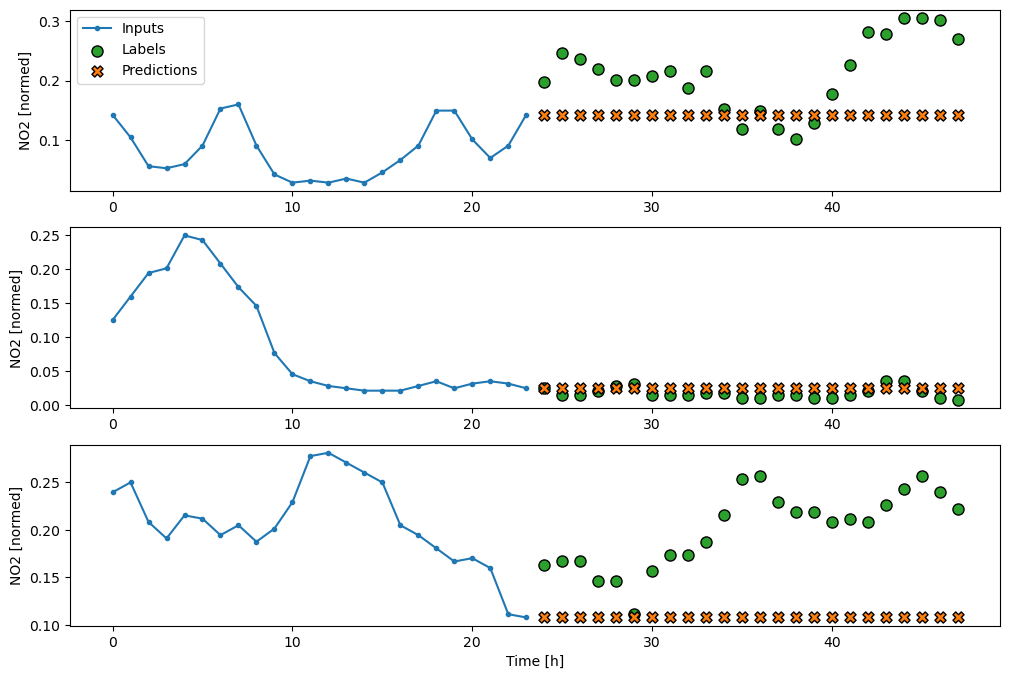

In [82]:
multi_window.plot(baseline_last)

In [83]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [85]:
baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 863us/step - loss: 0.1482 - mean_absolute_error: 0.2876


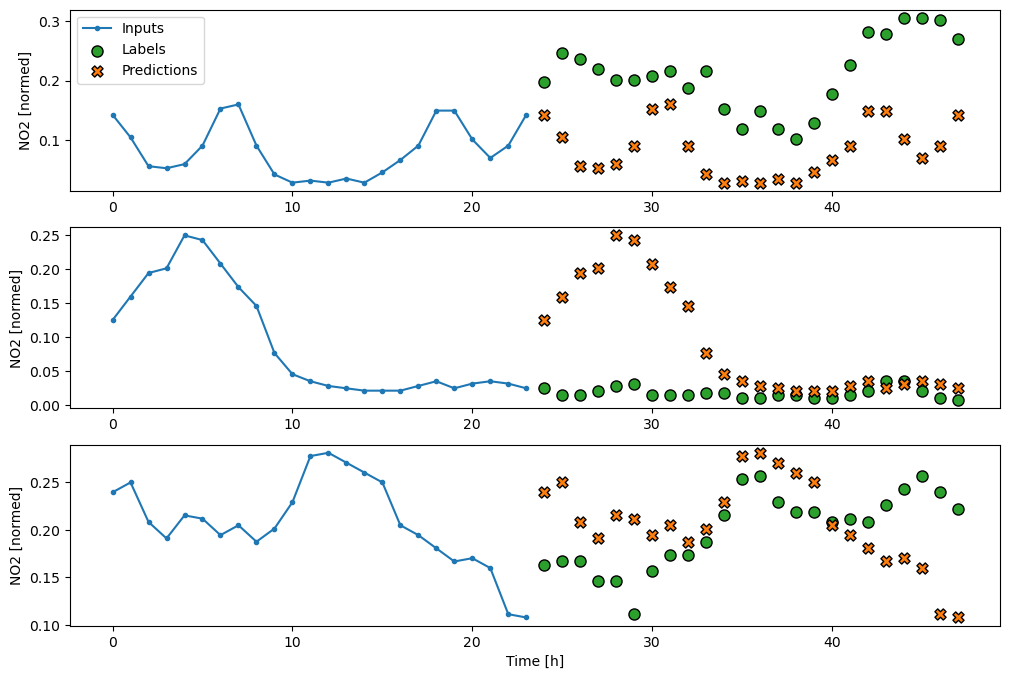

In [87]:
multi_window.plot(baseline_repeat)

#### Linear Model

In [88]:
# Linear Model
label_index = column_indices['NO2']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0154 - mean_absolute_error: 0.0941 - val_loss: 0.0098 - val_mean_absolute_error: 0.0745
Epoch 2/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0846 - val_loss: 0.0091 - val_mean_absolute_error: 0.0726
Epoch 3/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0119 - mean_absolute_error: 0.0835 - val_loss: 0.0089 - val_mean_absolute_error: 0.0715
Epoch 4/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0828 - val_loss: 0.0088 - val_mean_absolute_error: 0.0711
Epoch 5/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0823 - val_loss: 0.0087 - val_mean_absolute_error: 0.0707
Epoch 6/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0820 - val_loss: 0.0087 - val_mean_absolute_error: 0.0705
Epoch 7/50
413/4

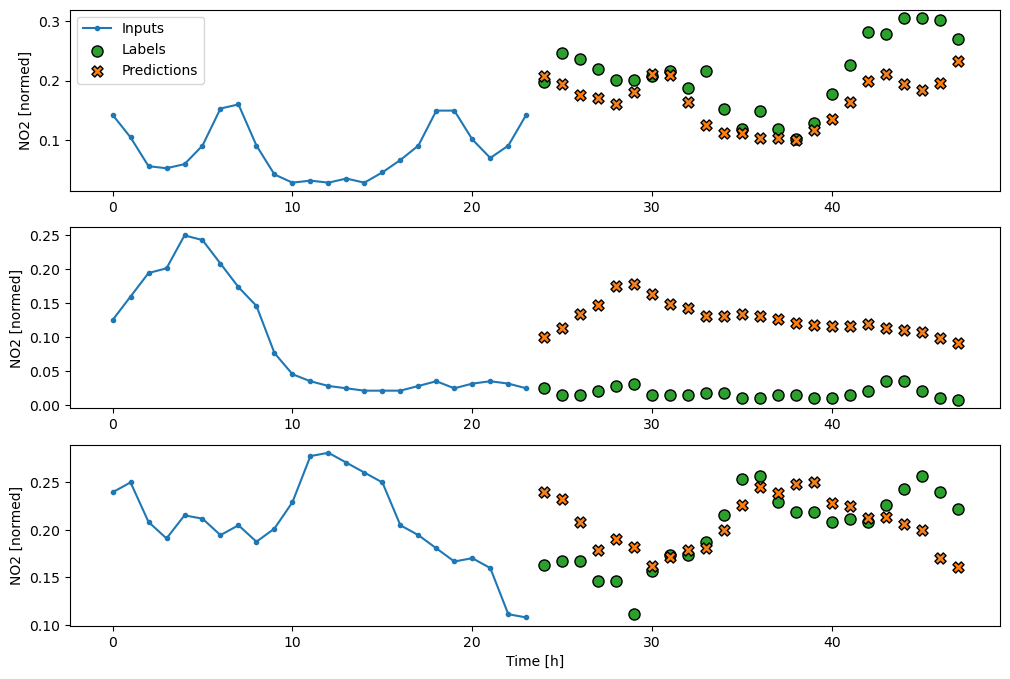

In [89]:
multi_window.plot(linear)

#### Deep Neural Network

In [96]:
# Deep Neural Network
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0858 - val_loss: 0.0086 - val_mean_absolute_error: 0.0687
Epoch 2/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0800 - val_loss: 0.0086 - val_mean_absolute_error: 0.0688
Epoch 3/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0785 - val_loss: 0.0086 - val_mean_absolute_error: 0.0695
Epoch 4/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0107 - mean_absolute_error: 0.0780 - val_loss: 0.0089 - val_mean_absolute_error: 0.0696
Epoch 5/50
117/117 [==============================] - 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0693


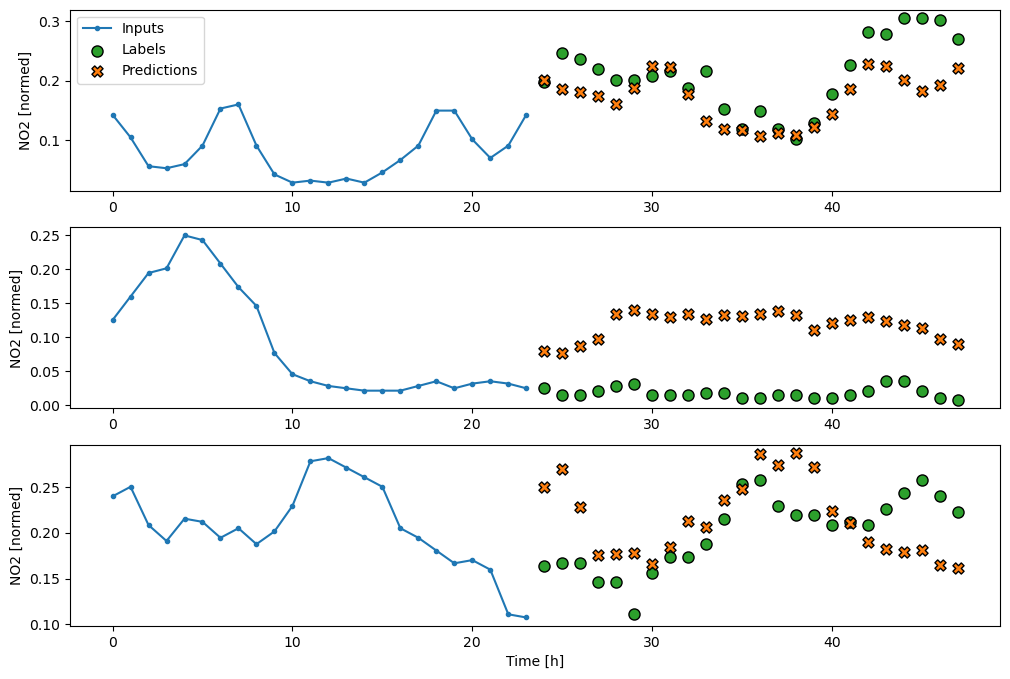

In [97]:
# Plot the prediction
multi_window.plot(dense)

#### LSTM

In [98]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 5s 8ms/step - loss: 0.0146 - mean_absolute_error: 0.0915 - val_loss: 0.0094 - val_mean_absolute_error: 0.0719
Epoch 2/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0117 - mean_absolute_error: 0.0825 - val_loss: 0.0093 - val_mean_absolute_error: 0.0714
Epoch 3/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0112 - mean_absolute_error: 0.0806 - val_loss: 0.0085 - val_mean_absolute_error: 0.0696
Epoch 4/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0109 - mean_absolute_error: 0.0795 - val_loss: 0.0084 - val_mean_absolute_error: 0.0697
Epoch 5/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0788 - val_loss: 0.0083 - val_mean_absolute_error: 0.0685
Epoch 6/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0105 - mean_absolute_error: 0.0778 - val_loss: 0.0084 - val_mean_absolute_error: 0.0691
Epoch 7/50
413/4

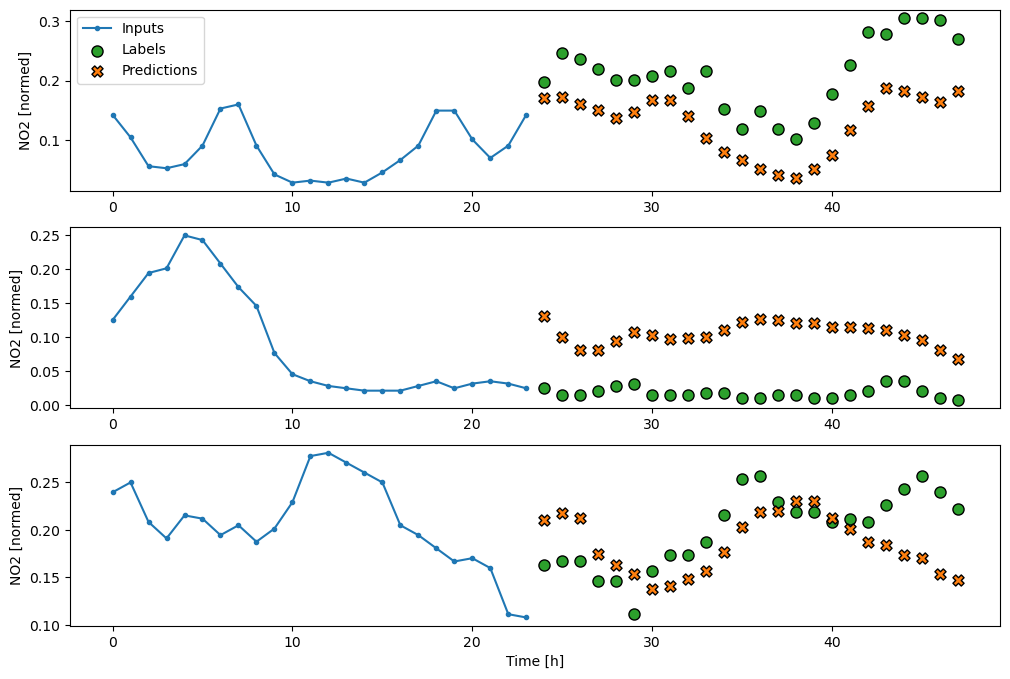

In [99]:
# Plot the prediction
multi_window.plot(lstm_model)

#### CNN

Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0881 - val_loss: 0.0085 - val_mean_absolute_error: 0.0690
Epoch 2/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0110 - mean_absolute_error: 0.0792 - val_loss: 0.0085 - val_mean_absolute_error: 0.0686
Epoch 3/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0782 - val_loss: 0.0083 - val_mean_absolute_error: 0.0687
Epoch 4/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0775 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 5/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0768 - val_loss: 0.0089 - val_mean_absolute_error: 0.0702
Epoch 6/50
117/117 [==============================] - 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0690


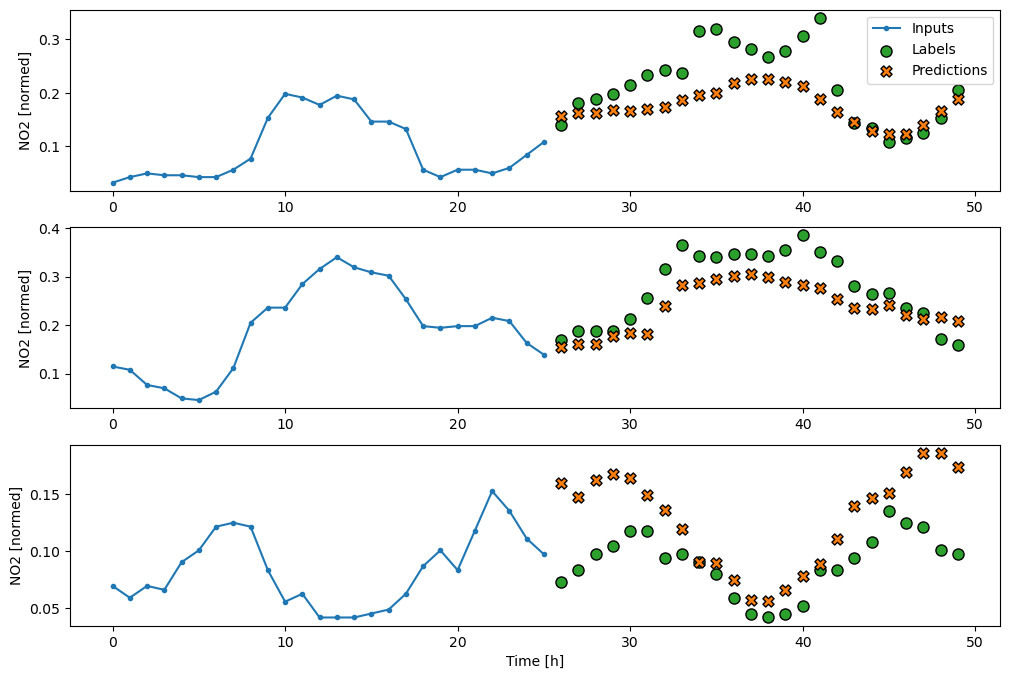

In [101]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['NO2'])

cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

cnn_multi_window.plot(cnn_model)

#### CNN + LSTM

Epoch 1/50
413/413 [==============================] - 5s 8ms/step - loss: 0.0141 - mean_absolute_error: 0.0901 - val_loss: 0.0087 - val_mean_absolute_error: 0.0699
Epoch 2/50
413/413 [==============================] - 3s 8ms/step - loss: 0.0113 - mean_absolute_error: 0.0808 - val_loss: 0.0085 - val_mean_absolute_error: 0.0683
Epoch 3/50
413/413 [==============================] - 3s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.0791 - val_loss: 0.0084 - val_mean_absolute_error: 0.0685
Epoch 4/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0107 - mean_absolute_error: 0.0785 - val_loss: 0.0085 - val_mean_absolute_error: 0.0682
Epoch 5/50
413/413 [==============================] - 3s 7ms/step - loss: 0.0104 - mean_absolute_error: 0.0774 - val_loss: 0.0086 - val_mean_absolute_error: 0.0687
Epoch 6/50
117/117 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0704


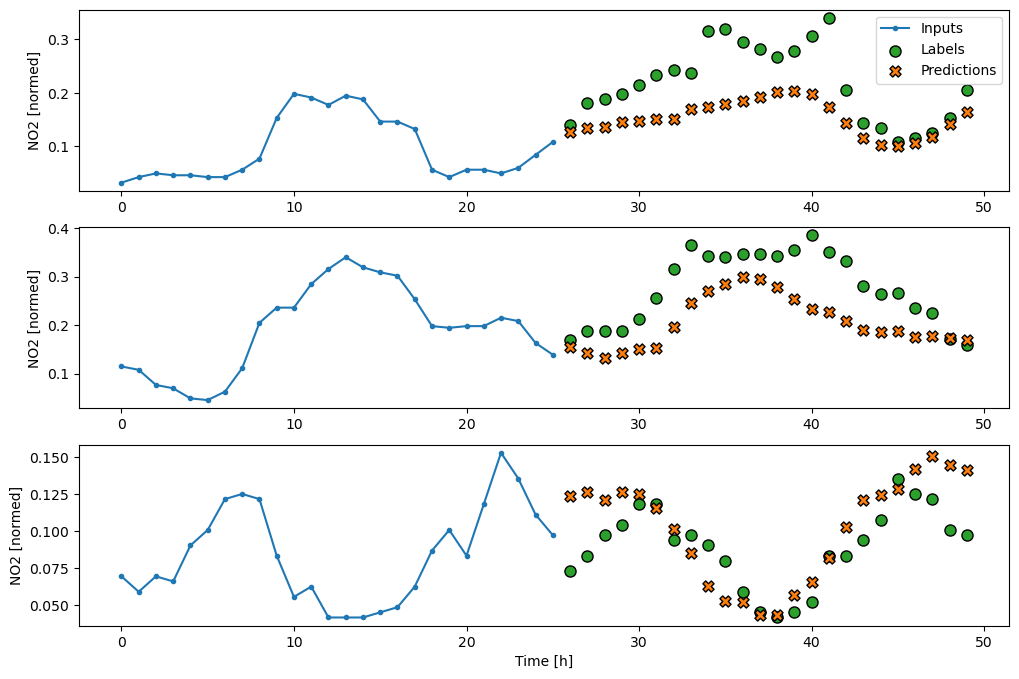

In [102]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)


cnn_multi_window.plot(cnn_lstm_model)

#### ARLSTM

In [103]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

Epoch 1/50
413/413 [==============================] - 7s 10ms/step - loss: 0.0136 - mean_absolute_error: 0.0889 - val_loss: 0.0087 - val_mean_absolute_error: 0.0701
Epoch 2/50
413/413 [==============================] - 4s 9ms/step - loss: 0.0107 - mean_absolute_error: 0.0790 - val_loss: 0.0103 - val_mean_absolute_error: 0.0755
Epoch 3/50
413/413 [==============================] - 4s 9ms/step - loss: 0.0101 - mean_absolute_error: 0.0763 - val_loss: 0.0083 - val_mean_absolute_error: 0.0674
Epoch 4/50
413/413 [==============================] - 4s 8ms/step - loss: 0.0096 - mean_absolute_error: 0.0744 - val_loss: 0.0073 - val_mean_absolute_error: 0.0644
Epoch 5/50
413/413 [==============================] - 4s 9ms/step - loss: 0.0094 - mean_absolute_error: 0.0733 - val_loss: 0.0083 - val_mean_absolute_error: 0.0667
Epoch 6/50
413/413 [==============================] - 4s 9ms/step - loss: 0.0091 - mean_absolute_error: 0.0718 - val_loss: 0.0078 - val_mean_absolute_error: 0.0646
Epoch 7/50
413/

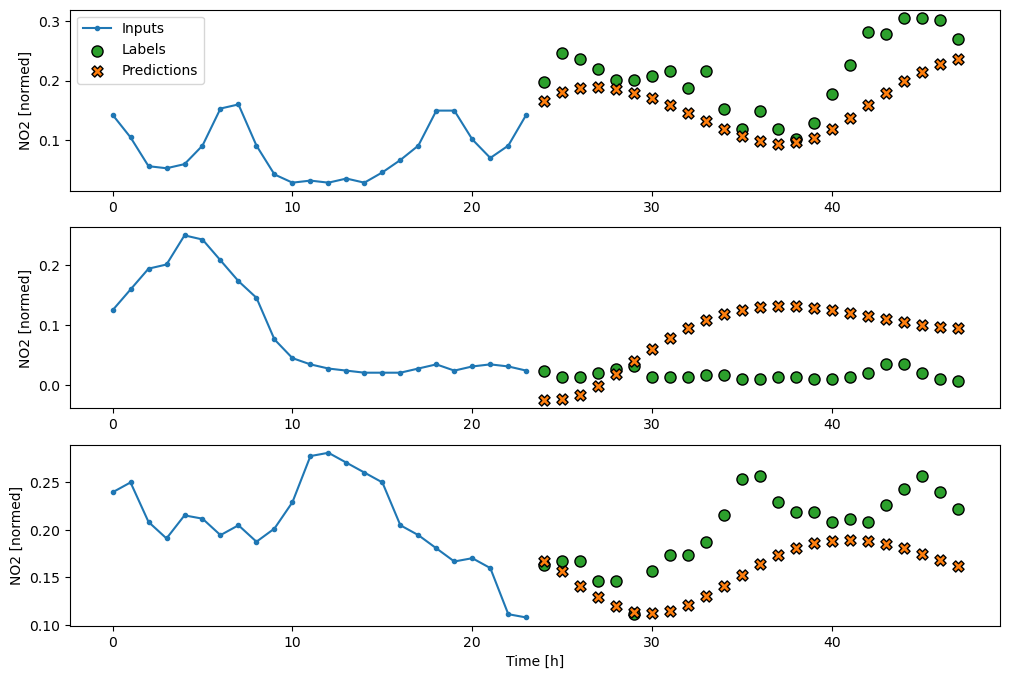

In [104]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

multi_window.plot(AR_LSTM)

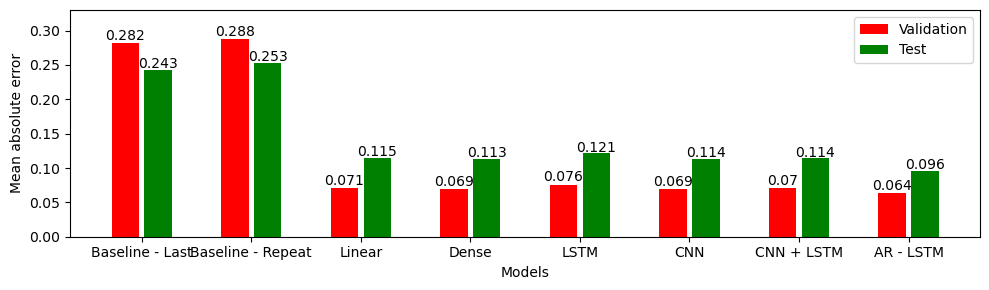

In [109]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots(figsize = (10,3))
ax.bar(x - 0.15, mae_val, width=0.25, color='red',  label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='green', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()